<a href="https://colab.research.google.com/github/zw2497/Neural_Network_PDE/blob/master/ODE2_Mid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip -q install tf-nightly-2.0-preview

In [0]:
import tensorflow as tf 
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.math import sin
import time
%matplotlib inline

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.nn import relu

In [33]:
print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-dev20190427


# Build Function

In [0]:
def f(x):
    return sin(x) + 4 * sin(4*x) - 8 * sin(8*x) + 16 * sin(24*x)

def psy_trial(x, net_out):
    return (-1. - x) * (1. - x) * net_out

# Build Neural Network

In [0]:
model = Sequential()
model.add(Dense(128, input_shape=(None, 1), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(0.0005)

# Prepare Dataset

In [0]:
nx = 100
x_space = np.linspace(-1, 1, nx).astype('float32').reshape(nx,1)
x_space = tf.constant(x_space)

batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(x_space).batch(batch_size, drop_remainder=True)

In [56]:
example_batch = next(iter(dataset))
source = example_batch
print("Shapes:", source.shape)

Shapes: (16, 1)


# Train

In [0]:
def loss_function(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred)

In [0]:
# @tf.function
def train_on_batch(x):
    with tf.GradientTape() as g_total:
        with tf.GradientTape() as g:
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                net_out = model(x)
                psy_t = psy_trial(x, net_out)

            dy_dx = gg.gradient(psy_t, x)     # gradient
        d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient
        
        func = f(x) # right part function
        loss = loss_function(-d2y_dx2, func)
#         print(d2y_dx2)

    grads = g_total.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return tf.math.reduce_sum(loss)

In [59]:
for epoch in range(1000):
    for batch, source_data in enumerate(dataset):
        start = time.time()
        loss = train_on_batch(source_data)
    print("Epoch #%d, Loss %.6f, Time %.2f sec" % (epoch, loss, time.time() - start))

Epoch #0, Loss 1837.426514, Time 0.01 sec
Epoch #1, Loss 1755.650879, Time 0.02 sec
Epoch #2, Loss 1693.449951, Time 0.01 sec
Epoch #3, Loss 1652.986328, Time 0.01 sec
Epoch #4, Loss 1629.021729, Time 0.01 sec
Epoch #5, Loss 1615.858887, Time 0.01 sec
Epoch #6, Loss 1609.046265, Time 0.01 sec
Epoch #7, Loss 1605.624390, Time 0.01 sec
Epoch #8, Loss 1603.850342, Time 0.01 sec
Epoch #9, Loss 1602.801025, Time 0.01 sec
Epoch #10, Loss 1602.033691, Time 0.01 sec
Epoch #11, Loss 1601.354492, Time 0.01 sec
Epoch #12, Loss 1600.684937, Time 0.01 sec
Epoch #13, Loss 1599.994385, Time 0.02 sec
Epoch #14, Loss 1599.270142, Time 0.01 sec
Epoch #15, Loss 1598.505981, Time 0.01 sec
Epoch #16, Loss 1597.697754, Time 0.01 sec
Epoch #17, Loss 1596.841675, Time 0.01 sec
Epoch #18, Loss 1595.934326, Time 0.01 sec
Epoch #19, Loss 1594.972046, Time 0.01 sec
Epoch #20, Loss 1593.950439, Time 0.01 sec
Epoch #21, Loss 1592.865112, Time 0.01 sec
Epoch #22, Loss 1591.711060, Time 0.01 sec
Epoch #23, Loss 1590.

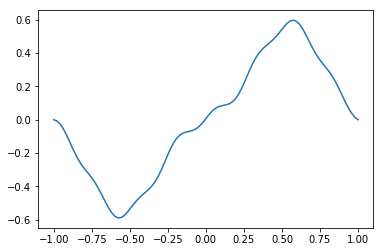

In [61]:
plt.figure()
res = psy_trial(x_space, model(x_space)).numpy().reshape(nx)
plt.plot(x_space, -res)
plt.show()